# Seq2seq 기반 번역기 만들기

Seq2seq이 번역기에 최적화되어 있는 만큼, 이번 코스에선 Seq2seq 기반 번역기를 직접 만들어보며 그 구조를 이해해보도록 하겠습니다.  
또한 Attention 기법을 추가하여 성능을 높여보기도 할 거고요!

실습에는 영어-스페인어 말뭉치를 사용하지만 직접 하실 프로젝트는 한국어-영어 말뭉치를 사용할 것입니다.

matplotlib 라이브러리에 한국어를 지원하는 폰트로 변경

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontpath = 'C:\\Windows\\Fonts\\NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 데이터전처리

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.10.0


get_file() 함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 해 주는 함수이다.

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


In [4]:
path_to_file

'C:\\Users\\ziipp\\.keras\\datasets/spa-eng/spa.txt'

In [6]:
with open(path_to_file, "r", encoding="UTF8") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


### 데이터 전처리: 정제하기

\t 를 기준으로 영어와 스페인어로 분리 할 수 있겠다.  
! 과 같은 특수문자는 제외하겠다.

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 
    
이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 
    
원활한 학습을 위해 데이터는 상위 30,000 개만 사용하도록 하겠습니다.

In [8]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


### 데이터 전처리: 토큰화

정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환하세요.  
그리고 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리하세요! (Tokenizer의 단어 수는 자유롭게 진행하세요!)

In [9]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [10]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


## 모델 설계

아래 그림처럼 각각 1개의 GRU 를 갖는 Encoder-Decoder 구조를 설계할 것이다.

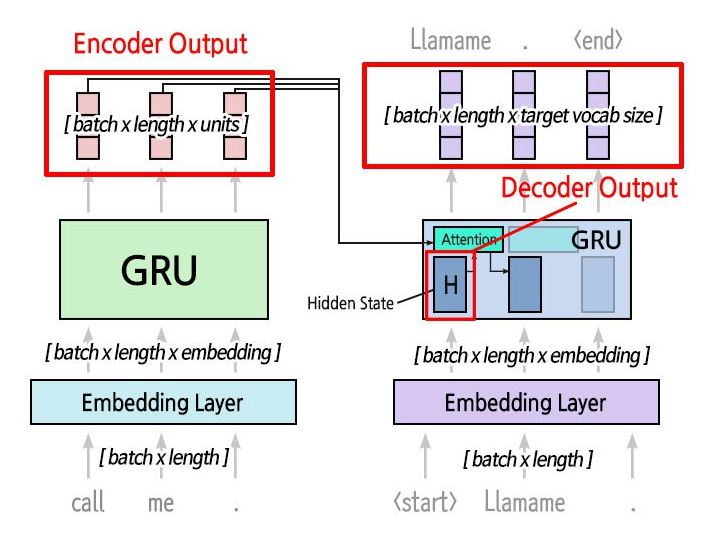

In [11]:
from IPython.display import Image
Image(filename='capture/11_gru_architecture.png') 

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고,  
Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.

Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

Attention은 Bahdanau을 사용할 예정입니다.

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


위 그림과 동일하게 Encoder 클래스와 Deocder 클래스를 작성해라.

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        #
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, 
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)        
        return out

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        #
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        #
        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [16]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 훈련하기 (1) Optimizer & Loss

지금까지는 fit() 함수로 간편하게 학습을 진행했지만, Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 한다.

### Otimizer & Loss

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법 정도로 설명할 수 있는데, 일반적으론 Adam 외의 것을 사용하지 않으니 후에 실력이 더 늘어나고 나서 공부하시는 것을 권장합니다!

여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문입니다. 

앞서 설명한 것처럼 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하기 때문이죠.

SparseCategoricalCrossentropy() 함수는 
- 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줍니다. 

CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. 

from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. 

우리는 True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다!

데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 패딩(Padding) 과정을 거친 것을 기억하나요?  
tokenize() 함수 내부의 pad_sequences() 가 바로 그 역할을 해주는 녀석이었죠!

만약 모델에게 <PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 <PAD> 로 이뤄져 있다고 생각하게 됩니다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고나 할까요...? 어떤 시험이 한 번호로만 찍어도 80점 이상을 받을 수 있다면 그 시험은 공부를 절대 하지 않겠죠! 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 <PAD> 토큰만을 생성할 확률이 굉장히 높아집니다.
    
이 문제를 방지하기 위해 mask 가 사용됩니다! 
    
mask 는 정답지에서 <PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠.  
equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

## 훈련하기 (2) train_step 구현하기

train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 먼저 구성을 보시죠!

In [18]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


- Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
- t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
- Decoder에 입력으로 전달할 <start> 토큰 문장 생성
- <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
- 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
- 반복!

## 훈련하기 (3) 훈련 시작하기

In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

## 실습하기

Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의하세요! 

그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행하도록 소스를 수정하세요! 결과는 아래와 같은 형태가 되어야 합니다.

In [20]:
# eval_step() 정의하기
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

# train_step() 이후 eval_step() 진행하도록 소스 수정하기
from tqdm import tqdm

# EPOCHS = 10
EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  1: 100%|█████████████████████████████████████████████████| 94/94 [00:45<00:00,  2.06it/s, Test Loss 0.6907]


### 평가 및 시각화

훈련이 완료된 모델은 아래 소스를 실행해 번역 성능을 평가할 수 있어요. Attention Map을 시각화하는 것는 보너스!

Input: can i have some coffee ?
Predicted translation: puedo tener un poco caf ? <end> 


C:\Users\ziipp\AppData\Local\Temp\ipykernel_29380\1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ziipp\AppData\Local\Temp\ipykernel_29380\1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


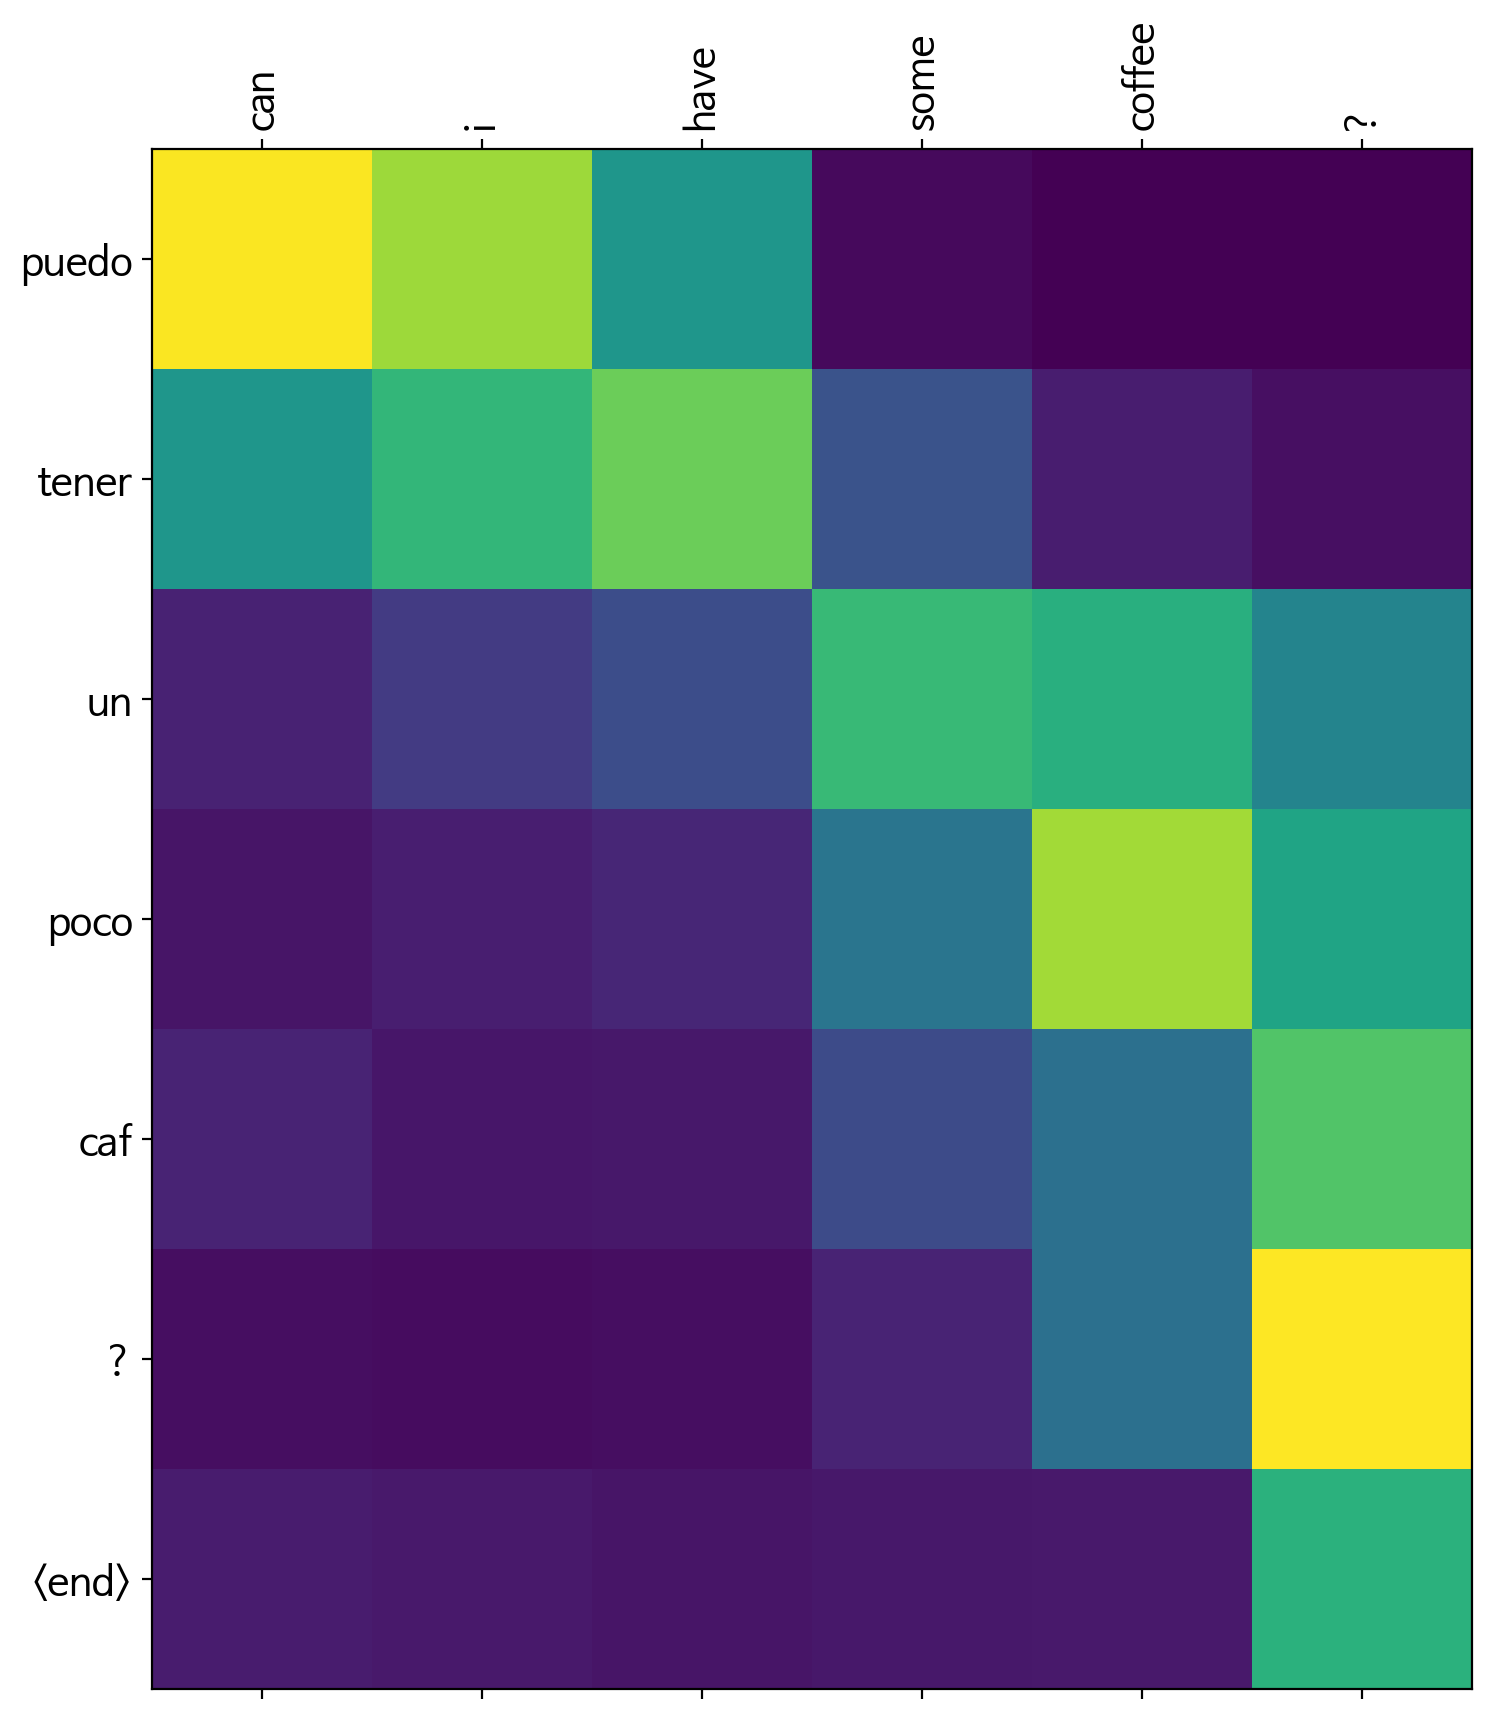

In [21]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

## (참고) 한영 번역기 만들기

데이터는 아래 링크에서 다운로드한다.  
https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [4]:
import MeCab
m = MeCab.Tagger()
a = m.parse("오늘은 좋은날, 행복한 삶을 누리자.")
print(a)

오늘	NNG,*,T,오늘,*,*,*,*
은	JX,*,T,은,*,*,*,*
좋	VA,*,T,좋,*,*,*,*
은	ETM,*,T,은,*,*,*,*
날	NNG,*,T,날,*,*,*,*
,	SC,*,*,*,*,*,*,*
행복	NNG,정적사태,T,행복,*,*,*,*
한	XSA+ETM,*,T,한,Inflect,XSA,ETM,하/XSA/*+ᆫ/ETM/*
삶	NNG,행위,T,삶,*,*,*,*
을	JKO,*,T,을,*,*,*,*
누리	VV,*,F,누리,*,*,*,*
자	EF,*,F,자,*,*,*,*
.	SF,*,*,*,*,*,*,*
EOS



In [1]:
import pandas
import tensorflow as tf
import numpy as np

import re
# from konlpy.tag import Mecab
from eunjeon import Mecab
mecab = Mecab()
# import MeCab
# mecab = MeCab.Tagger()

import random
from tqdm import tqdm

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

print(pandas.__version__)
print(tf.__version__)
print(matplotlib.__version__)

1.5.1
2.10.0
3.6.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontpath = 'C:\\Windows\\Fonts\\NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [3]:
# 데이터 불러오기
import os

#경로를 설정해주세요.
# kor_file = os.getenv('HOME')+"/data/korean-english-park.train.ko"
# eng_file = os.getenv('HOME')+"/data/korean-english-park.train.en"
kor_file = "./data/korean-english-park.train.ko"
eng_file = "./data/korean-english-park.train.en"

with open(kor_file, "r", encoding="UTF8") as f:
    kor_raw = f.read().splitlines()

with open(eng_file, "r", encoding="UTF8") as f:
    eng_raw = f.read().splitlines()

print("kor Data Size:", len(kor_raw))
print("eng Data Size:", len(eng_raw))

kor Data Size: 94123
eng Data Size: 94123


In [4]:
# 어떤 데이터인지 확인해봅시다.
print("Example:")
for i in range(4):
    print("kor:", kor_raw[i])
    print("eng:", eng_raw[i])
    print()

Example:
kor: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
eng: Much of personal computing is about "can you top this?"

kor: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
eng: so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

kor: 그러나 이것은 또한 책상도 필요로 하지 않는다.
eng: Like all optical mice, But it also doesn't need a desk.

kor: 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
eng: uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.



### 데이터 정제

- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
- 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!
- 타겟 언어인 영문엔 `<start>` 토큰과 `<end>` 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

In [5]:
# 1) cleaned_corpus에 set을 활용하여 중복데이터를 제거합니다
cleaned_corpus = list(set(zip(kor_raw, eng_raw)))
print(cleaned_corpus[1])
print(len(cleaned_corpus))

('그는 “수십대의 챠량이 한꺼번에 밑 으로 떨어졌다”며 “경찰이 차량 유리 위로 지나가며 생존자가 있는지 확인하는 모습이 보였다”고 주장했다.', 'Another witness was walking on a pedestrian bridge nearby when he saw the disaster. "There were several cars completely just crushed.')
78968


In [6]:
# 2) 한글 정규식을 추가합니다.
# from konlpy.tag import Mecab
from eunjeon import Mecab
mecab = Mecab()
# import MeCab
# mecab = MeCab.Tagger()

def ko_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()
    sentence = mecab.morphs(sentence)

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [7]:
# 3) 영어 정규식도 함수로 정의해봅시다
# `<start>` 토큰과 `<end>` 토큰을 추가하고 `split()` 함수를 이용해 토큰화합니다.
def en_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

In [8]:
kor_raw_corpus = []
eng_raw_corpus = []

for kor, eng in cleaned_corpus:
    kor_raw_corpus.append(ko_preprocess_sentence(kor))
    eng_raw_corpus.append(en_preprocess_sentence(eng,s_token=True, e_token=True))

print("korean:", kor_raw_corpus[10])
print("english:", eng_raw_corpus[10])

korean: ['영국', '일간', '선', 'Sun', '은', '일', '오전', '현지', '시간', '잭슨', '에', '관한', '책', '을', '발간', '할', '저자', '의', '말', '을', '인용', ',', '잭슨', '이', '폐', '이식', '수술', '이', '필요', '한', '치명', '적', '병', '으로', '투병', '중', '이', '라는', '기사', '를', '보도', '해', '소동', '을', '벌였', '다', '.']
english: ['<start>', 'the', 'united', 'kingdom', 's', 'sun', 'newspaper', 'started', 'a', 'stir', 'monday', 'morning', 'when', 'it', 'quoted', 'the', 'author', 'of', 'an', 'upcoming', 'book', 'about', 'jackson', 'saying', 'he', 'was', 'battling', 'a', 'potentially', 'fatal', 'disease', 'that', 'required', 'a', 'life', 'saving', 'lung', 'transplant', '.', '<end>']


In [9]:
# eng_corpus와 kor_corpus에 토큰의 길이가 40 이하인 데이터를 선별합니다.
kor_corpus = []
eng_corpus = []
len_num = len(kor_raw_corpus)
print(len_num)

for i in range(len_num):
    if len(kor_raw_corpus[i]) <= 40 and len(eng_raw_corpus[i]) <= 40:
        kor_corpus.append(kor_raw_corpus[i])
        eng_corpus.append(eng_raw_corpus[i])

78968


### 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 

단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

In [10]:
# 토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

print("korean Vocab Size:", len(kor_tokenizer.index_word))
print("english Vocab Size:", len(eng_tokenizer.index_word))

korean Vocab Size: 43633
english Vocab Size: 38350


### 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 

앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [12]:
# BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [13]:
# Encoder

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        #
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [14]:
# Decoder

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [15]:
# Embedding Size와 Hidden Size는 적당한 값으로 찾아보세요.

BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 30, 1024)
Decoder Output: (128, 38351)
Decoder Hidden State: (128, 1024)
Attention: (128, 30, 1)


In [16]:
# Optimizer & Loss
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [17]:
# train_step 구현하기
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다!  
매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요!  
(Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.


(예문)  
K1) 오바마는 대통령이다.  
K2) 시민들은 도시 속에 산다.  
K3) 커피는 필요 없다.  
K4) 일곱 명의 사망자가 발생했다.  

(제출)  
E1) obama is the president . <end>  
E2) people are victims of the city . <end>  
E2) the price is not enough . <end>  
E2) seven people have died . <end>

In [18]:
# Training Process
#50분정도 소요됩니다.
# EPOCHS = 5
EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch  1: 100%|███████████████████████████████████████████████████████| 491/491 [1:53:37<00:00, 13.89s/it, Loss 3.8617]


In [19]:
# 시각화
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = ko_preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [20]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [21]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split())

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the u . s . <end> 


C:\Users\ziipp\AppData\Local\Temp\ipykernel_13460\421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ziipp\AppData\Local\Temp\ipykernel_13460\421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


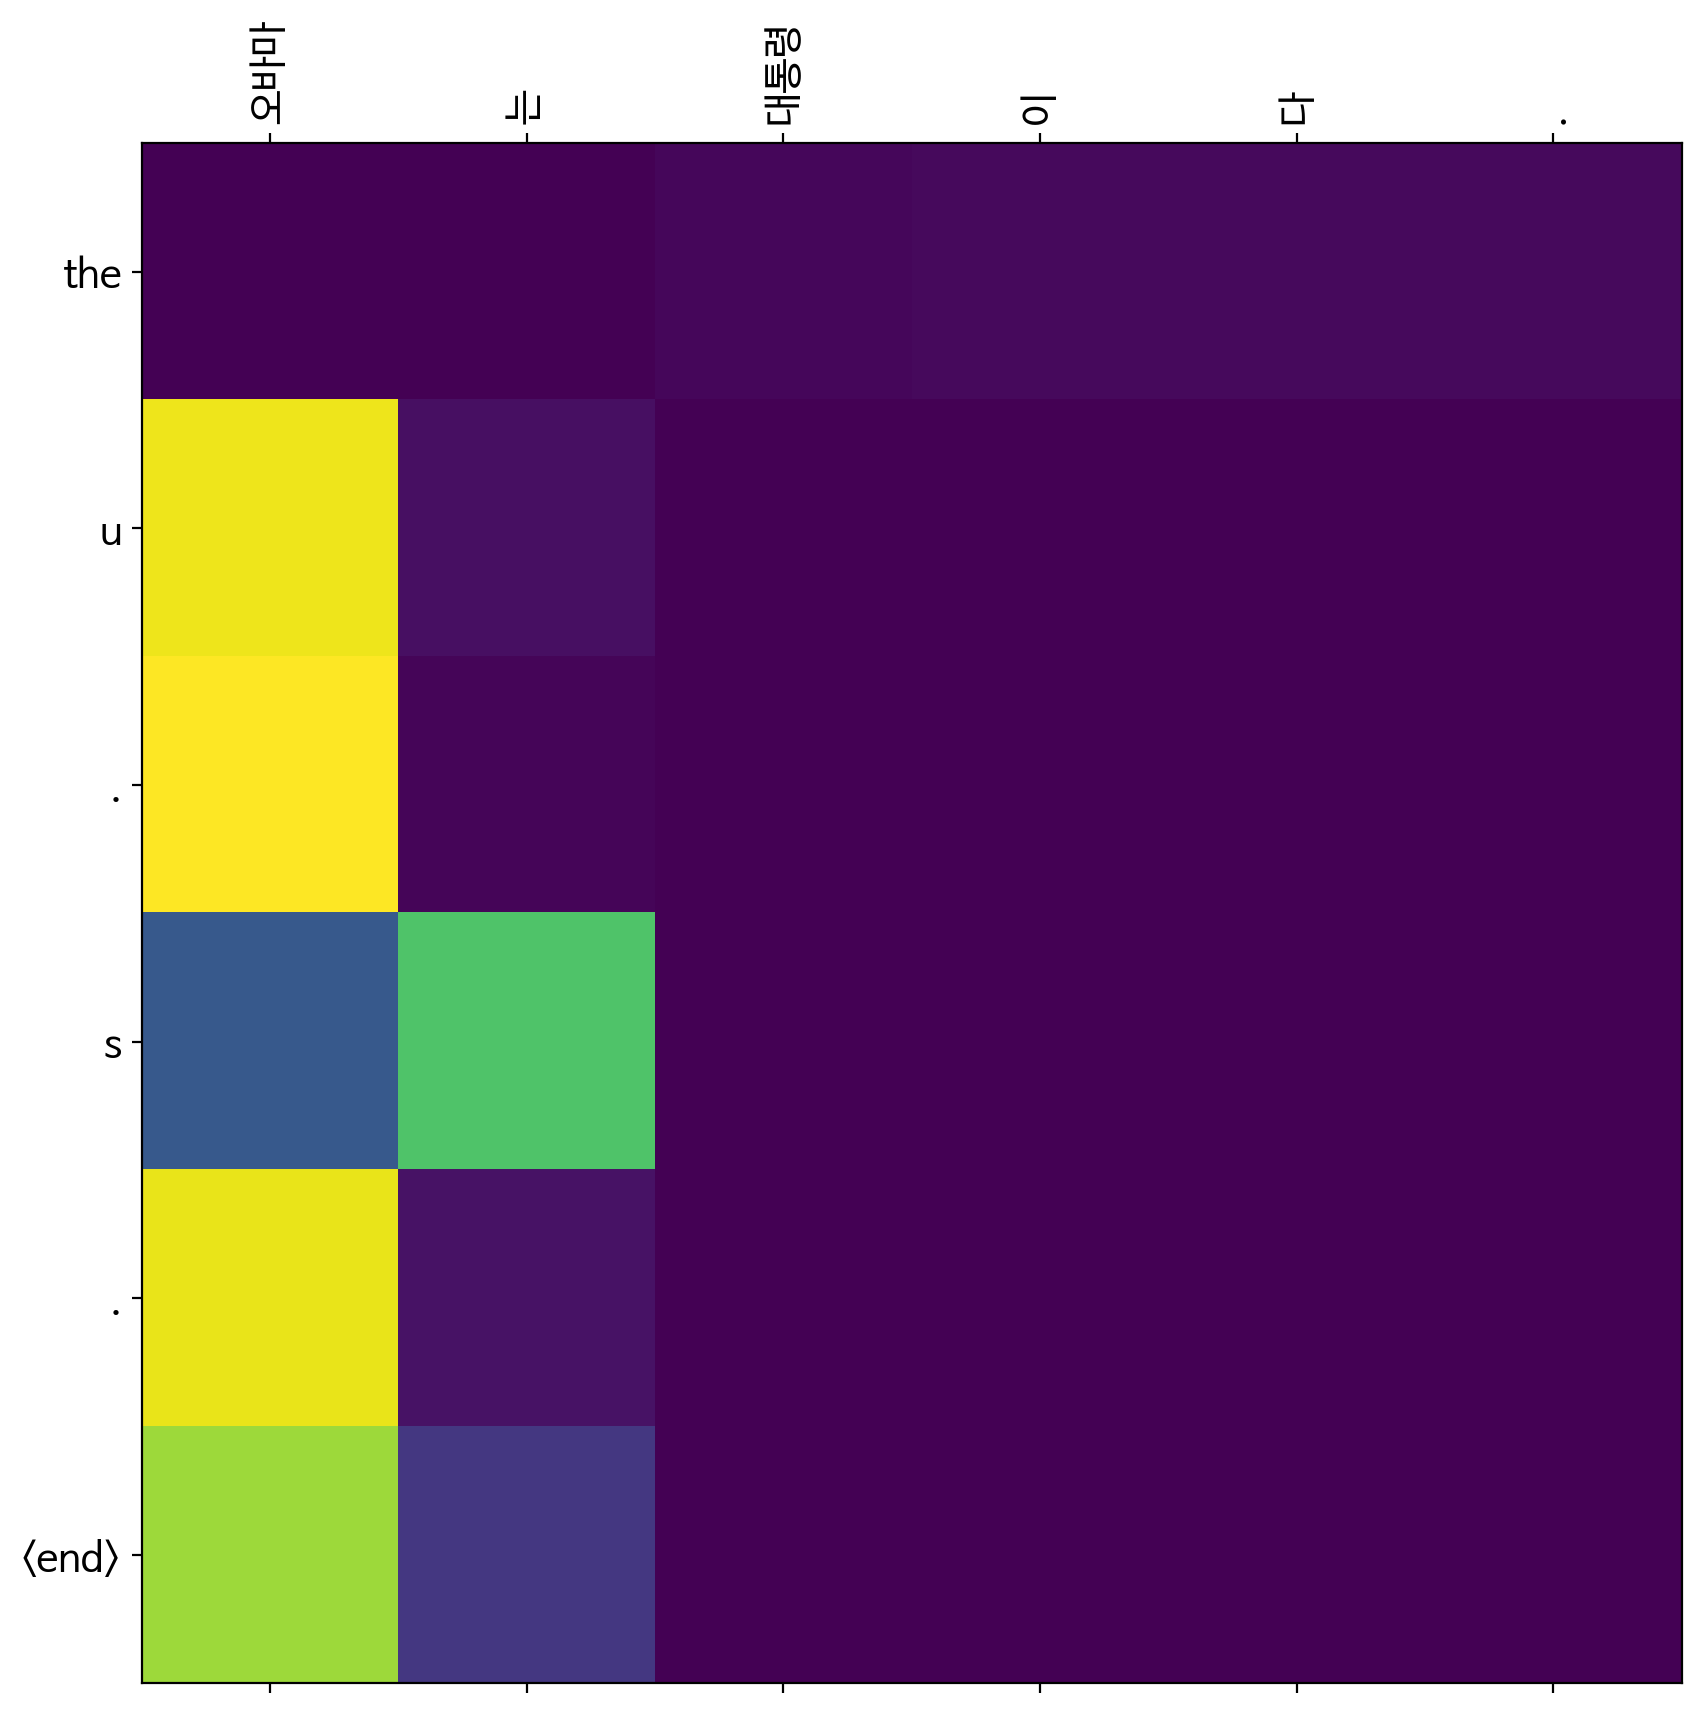

In [22]:
translate("오바마는 대통령이다.", encoder, decoder)